In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import nltk                            # Cleaning the data
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import os
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from keras.preprocessing import sequence,text
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM,SpatialDropout1D,Bidirectional
from keras.utils import to_categorical
from tensorflow.python.client import device_lib 
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.layers import Embedding, Dense, GRU, Dropout, Bidirectional, SpatialDropout1D

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
print(device_lib.list_local_devices()) 

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14818889100895624635
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16750052256874435547
physical_device_desc: "device: XLA_CPU device"
]


In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rajau\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Usefull Functions

In [5]:
# get train_test split of each target df

def get_traintestsplit(df):
    train_X = df['Tweet']
    stance =  df['Stance']

    return train_test_split( train_X, stance , test_size = 0.2, random_state = 42)

In [6]:
# function to generate X and Y of test set

def generate_XY(df):
    X = df.iloc[:,0]
    Y = df.iloc[:,2]
    return X,Y

In [7]:
# function to swap columns

def swap_columns(df):
    cols = list(df.columns)
    a, b = cols.index('Target'), cols.index('Tweet')
    cols[b], cols[a] = cols[a], cols[b]
    df = df[cols]
    return df

In [8]:
# max length of the tweet to fix our padding

def get_maxlength_tweet(df):
    tweet_len=[]
    for text in df['Tweet']:
        word=word_tokenize(text)
        l=len(word)
        tweet_len.append(l)

    return np.max(tweet_len)

In [9]:
# Function to deal with embedding file

def get_coef(word, *arr):
    return word, np.asarray(arr, dtype='float32')
    
def get_emb_matrix(EMB_FILE, max_feature,emb_dimension, tokenizer):
    # word vectors
    emb_index = dict(get_coef(*x.rstrip().rsplit(' ')) for x in open(EMB_FILE, encoding='utf8'))
    print('Found %s word vectors.' % len(emb_index))

    # embedding matrix
    word_index = tokenizer.word_index
    num_words = min(max_feature, len(word_index) + 1)
    all_emb = np.stack(emb_index.values()) #for random init
    emb_matrix = np.random.normal(all_emb.mean(), all_emb.std(), (num_words, emb_dimension))
    
    for word, i in word_index.items():
        if i >= max_feature:
            continue
        emb_vector = emb_index.get(word)
        if emb_vector is not None:
            emb_matrix[i] = emb_vector
    max_feature = emb_matrix.shape[0]
    return emb_matrix

In [10]:
# Tokenize test data

def tokenize_testdata(testdf, max_feature, tokenizer):
    testdf = tokenizer.texts_to_sequences(testdf)

    return testdf

In [11]:
# Tokenize train data

def tokenize_traindata(X_train, X_val, max_feature):
    tokenizer = Tokenizer(num_words=max_feature)
    tokenizer.fit_on_texts(list(X_train))
    X_train = tokenizer.texts_to_sequences(X_train)
    X_val = tokenizer.texts_to_sequences(X_val)
    return X_train, X_val,tokenizer

In [12]:
# Padding our input data to make a vector of consistent size

def padding_traindata(X_train, X_val, max_word):
    X_train = sequence.pad_sequences(X_train, maxlen=max_word)
    X_val = sequence.pad_sequences(X_val, maxlen=max_word)
    return X_train, X_val

In [13]:
# Padding our test data to make a vector of consistent size

def padding_testdata(testdf, max_word):
    testdf = sequence.pad_sequences(testdf, maxlen=max_word)
    
    return testdf

In [14]:
# Label encoding (Y) train Target variable 

def label_encoding_train(Y_train, Y_val): 
    le = preprocessing.LabelEncoder()
    le.fit(Y_train)
    Y_train = le.transform(Y_train)
    Y_val = le.transform(Y_val)

    Y_train = to_categorical(Y_train, dtype ="uint8") 
    Y_val = to_categorical(Y_val, dtype ="uint8") 
    return Y_train, Y_val, le

In [15]:
# Label encoding (Y) test Target variable 

def label_encoding_test(Y_test, le): 
    Y_test = le.transform(Y_test) 
    
    return Y_test

### Data Handling

In [16]:
trainData = pd.read_pickle('../Pickle_files/train_data.pkl')

In [17]:
testData = pd.read_pickle('../Pickle_files/test_data.pkl')

In [18]:
independentData = pd.read_pickle('../Pickle_files/indep_eval_data2.pkl')

In [19]:
independentData.Stance.unique()

array(['AGAINST', 'NONE', 'FAVOR', nan], dtype=object)

In [20]:
testData.Stance.unique()

array(['AGAINST', 'FAVOR', 'NONE'], dtype=object)

In [21]:
print(trainData.shape)
print(testData.shape)
print(independentData.shape)

(2914, 3)
(1956, 3)
(53, 3)


In [22]:
trainData.Target.value_counts()

Hillary Clinton                     689
Feminist Movement                   664
Legalization of Abortion            653
Atheism                             513
Climate Change is a Real Concern    395
Name: Target, dtype: int64

In [23]:
testData.Target.value_counts()

Donald Trump                        707
Hillary Clinton                     295
Feminist Movement                   285
Legalization of Abortion            280
Atheism                             220
Climate Change is a Real Concern    169
Name: Target, dtype: int64

In [24]:
independentData.Target.value_counts()

Hillary Clinton                     13
Climate Change is a Real Concern    11
Legalization of Abortion            10
feminist movement                    9
Atheism                              9
                                     1
Name: Target, dtype: int64

In [25]:
# # converting all target variables to lower

# trainData.Target = trainData.Target.str.lower()
# testData.Target = trainData.Target.str.lower()
# independentData.Target = independentData.Target.str.lower()

In [26]:
independentData = swap_columns(independentData)

In [27]:
# splitting data into multiple dataframes based on target values (train data)

hc_traindf =trainData[trainData['Target'] == 'Hillary Clinton']
fm_traindf =trainData[trainData['Target'] == 'Feminist Movement']
la_traindf =trainData[trainData['Target'] == 'Legalization of Abortion']
at_traindf =trainData[trainData['Target'] == 'Atheism']
cc_traindf =trainData[trainData['Target'] == 'Climate Change is a Real Concern']

In [28]:
# splitting data into multiple dataframes based on target values (test data)

hc_testdf = testData[testData['Target'] == 'Hillary Clinton']
fm_testdf = testData[testData['Target'] == 'Feminist Movement']
la_testdf = testData[testData['Target'] == 'Legalization of Abortion']
at_testdf = testData[testData['Target'] == 'Atheism']
cc_testdf = testData[testData['Target'] == 'Climate Change is a Real Concern']

gen_testdf = testData[testData['Target'] == 'Donald Trump']

In [29]:
# splitting data into multiple dataframes based on target values (Independent data)

hc_indepdf =independentData[independentData['Target'] == 'Hillary Clinton']
fm_indepdf =independentData[independentData['Target'] == 'feminist movement']
la_indepdf =independentData[independentData['Target'] == 'legalization of Abortion']
at_indepdf =independentData[independentData['Target'] == 'Atheism']
cc_indepdf =independentData[independentData['Target'] == 'climate change']

In [30]:
# getting train test split values for each target df (train)

X_train1, X_val1, Y_train1, Y_val1 = get_traintestsplit(hc_traindf)
X_train2, X_val2, Y_train2, Y_val2 = get_traintestsplit(fm_traindf)
X_train3, X_val3, Y_train3, Y_val3 = get_traintestsplit(la_traindf)
X_train4, X_val4, Y_train4, Y_val4 = get_traintestsplit(at_traindf)
X_train5, X_val5, Y_train5, Y_val5 = get_traintestsplit(cc_traindf)

X_train6, X_val6, Y_train6, Y_val6 = get_traintestsplit(trainData)

In [31]:
# generating X and Y of test set

X_test1, Y_test1 = generate_XY(hc_testdf)
X_test2, Y_test2 = generate_XY(fm_testdf)
X_test3, Y_test3 = generate_XY(la_testdf)
X_test4, Y_test4 = generate_XY(at_testdf)
X_test5, Y_test5 = generate_XY(cc_testdf)

X_test6, Y_test6 = generate_XY(gen_testdf)

In [32]:
X_test1

674    mtp meetthepress deleting email government rec...
675    jdson andrewbroering andrewwhydoyoucareaboutwh...
676    white male vote solidly gop black vote solidly...
677    nyinvesting big banker bud need ratchet care l...
678    gop believe gop leader congress wont fight oba...
                             ...                        
964    looking ward hearing economic agenda monday ju...
965                 mataharikrishna loving draw contrast
966    finneyk stand msnbc anymore hope maddow need h...
967       create job time job outsourced monica lewinsky
968    amazing want secure border legal process immig...
Name: Tweet, Length: 295, dtype: object

In [33]:
# generating X and Y of independent set

X_indp1, Y_indp1 = generate_XY(hc_indepdf)
X_indp2, Y_indp2 = generate_XY(fm_indepdf)
X_indp3, Y_indp3 = generate_XY(la_indepdf)
X_indp4, Y_indp4 = generate_XY(at_indepdf)
X_indp5, Y_indp5 = generate_XY(cc_indepdf)

In [34]:
# # max length of the review

# max_tweet_len1 = get_maxlength_tweet(hc_df)
# max_tweet_len2 = get_maxlength_tweet(fm_df)
# max_tweet_len3 = get_maxlength_tweet(la_df)
# max_tweet_len4 = get_maxlength_tweet(at_df)
# max_tweet_len5 = get_maxlength_tweet(cc_df)

In [35]:
# List of max features - Max words
# [HC : 3313, LA : 3041, at : 2580, CC : 2327, FM: 3397]

In [36]:
# get tokenized X_train and Y_train

X_train1, X_val1, tok1 = tokenize_traindata(X_train1, X_val1, 3313)
X_train2, X_val2, tok2 = tokenize_traindata(X_train2, X_val2, 3397)
X_train3, X_val3, tok3 = tokenize_traindata(X_train3, X_val3, 3041)
X_train4, X_val4, tok4 = tokenize_traindata(X_train4, X_val4, 2580)
X_train5, X_val5, tok5 = tokenize_traindata(X_train5, X_val5, 2327)

X_train6, X_val6, tok6 = tokenize_traindata(X_train6, X_val6, 14658)

In [37]:
# get tokenized X_test and Y_test

X_test1 = tokenize_testdata(X_test1, 3313, tok1)
X_test2 = tokenize_testdata(X_test2, 3397, tok2)
X_test3 = tokenize_testdata(X_test3, 3041, tok3)
X_test4 = tokenize_testdata(X_test4, 2580, tok4)
X_test5 = tokenize_testdata(X_test5, 2327, tok5)

X_test6 = tokenize_testdata(X_test6, 14658, tok6)

In [38]:
# get tokenized X_indp and Y_indp

X_indp1 = tokenize_testdata(X_indp1, 3313, tok1)
X_indp2 = tokenize_testdata(X_indp2, 3397, tok2)
X_indp3 = tokenize_testdata(X_indp3, 3041, tok3)
X_indp4 = tokenize_testdata(X_indp4, 2580, tok4)
X_indp5 = tokenize_testdata(X_indp5, 2327, tok5)

In [39]:
# padding our dataframes (train)

X_train1, X_val1 = padding_traindata(X_train1, X_val1, 300)
X_train2, X_val2 = padding_traindata(X_train2, X_val2, 300)
X_train3, X_val3 = padding_traindata(X_train3, X_val3, 300)
X_train4, X_val4 = padding_traindata(X_train4, X_val4, 300)
X_train5, X_val5 = padding_traindata(X_train5, X_val5, 300)

X_train6, X_val6 = padding_traindata(X_train6, X_val6, 300)

In [40]:
# padding our dataframes (test)

X_test1 = padding_testdata(X_test1, 300)
X_test2 = padding_testdata(X_test2, 300)
X_test3 = padding_testdata(X_test3, 300)
X_test4 = padding_testdata(X_test4, 300)
X_test5 = padding_testdata(X_test5, 300)

X_test6 = padding_testdata(X_test6, 300)

In [41]:
# padding our dataframes (independent)

X_indp1 = padding_testdata(X_indp1, 300)
X_indp2 = padding_testdata(X_indp2, 300)
X_indp3 = padding_testdata(X_indp3, 300)
X_indp4 = padding_testdata(X_indp4, 300)
X_indp5 = padding_testdata(X_indp5, 300)

In [42]:
# Label encoding our Y (Target) variable (train)

Y_train1, Y_val1, le1 = label_encoding_train(Y_train1, Y_val1)
Y_train2, Y_val2, le2 = label_encoding_train(Y_train2, Y_val2)
Y_train3, Y_val3, le3 = label_encoding_train(Y_train3, Y_val3)
Y_train4, Y_val4, le4 = label_encoding_train(Y_train4, Y_val4)
Y_train5, Y_val5, le5 = label_encoding_train(Y_train5, Y_val5)

Y_train6, Y_val6, le6 = label_encoding_train(Y_train6, Y_val6)

In [43]:
# padding our dataframes (test)

Y_test1 = label_encoding_test(Y_test1, le1)
Y_test2 = label_encoding_test(Y_test2, le2)
Y_test3 = label_encoding_test(Y_test3, le3)
Y_test4 = label_encoding_test(Y_test4, le4)
Y_test5 = label_encoding_test(Y_test5, le5)

Y_test6 = label_encoding_test(Y_test6, le6)

In [44]:
# padding our dataframes (Independent)

Y_indp1 = label_encoding_test(Y_indp1, le1)
Y_indp2 = label_encoding_test(Y_indp2, le2)
Y_indp3 = label_encoding_test(Y_indp3, le3)
Y_indp4 = label_encoding_test(Y_indp4, le4)
Y_indp5 = label_encoding_test(Y_indp5, le5)

In [45]:
# loading our embedding file and storing words in matrix

EMB_FILE = '../Embeddings/glove.6B.300d.txt'
emb_dimension = 300 #word vector dim
emb_matrix1 = get_emb_matrix(EMB_FILE, 3313, emb_dimension, tok1)
emb_matrix2 = get_emb_matrix(EMB_FILE, 3397, emb_dimension, tok2)
emb_matrix3 = get_emb_matrix(EMB_FILE, 3041, emb_dimension, tok3)
emb_matrix4 = get_emb_matrix(EMB_FILE, 2580, emb_dimension, tok4)
emb_matrix5 = get_emb_matrix(EMB_FILE, 2327, emb_dimension, tok5)

Found 400000 word vectors.


C:\Users\rajau\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Found 400000 word vectors.
Found 400000 word vectors.
Found 400000 word vectors.
Found 400000 word vectors.


In [46]:
emb_matrix6 = get_emb_matrix(EMB_FILE, 14658, emb_dimension, tok6)

Found 400000 word vectors.


In [47]:
print(emb_matrix1.shape,emb_matrix2.shape,emb_matrix3.shape,emb_matrix4.shape,emb_matrix5.shape,emb_matrix6.shape)

(2308, 300) (2339, 300) (2125, 300) (1839, 300) (1717, 300) (7175, 300)


### LSTM Model

In [48]:
# Lets start our model building with a Single Layer LSTM and then we can built on it

# The reason why we are starting with LSTM is because we know its a very usefull model in NLP since it stores 
# the conext which is very important in our case

In [49]:
class StanceClassifierLSTM:
    
    def __init__(self, max_feature, num_classes):
        self.model = Sequential()
        self.max_feature = max_feature
        print(self.max_feature)
        self.num_classes = num_classes
        self.y_pred = 0
        self.history = 0
        
    def built_model(self, layers, emb_dimension, input_length1, emb_matrix):
        self.model.add(Embedding(self.max_feature, emb_dimension, input_length=input_length1,weights=emb_matrix,trainable=True))
        
        
        self.model.add(SpatialDropout1D(0.25))
        self.model.add((LSTM(64,return_sequences=False)))
        self.model.add(Dropout(0.5))
        
        self.model.add(Dense(3, activation='softmax'))
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
    def get_modelsummary(self):
        self.model.summary()
        
    def fit_model(self, X_train, Y_train, X_val, Y_val, epochs, batch_size):
        self.history =  self.model.fit(X_train, Y_train, validation_data=(X_val, Y_val),epochs=epochs,
                             batch_size=batch_size, verbose=1)
        return self.history
    
    def predict_model(self, X_test):
        self.y_pred = self.model.predict(X_test)
        return self.y_pred
    
    def evaluate_model(self, X_test, Y_test, le):
        Y_test = to_categorical(Y_test)
        print("result")
        print(self.model.evaluate(X_test,Y_test))       
        
    def display_confusionmatrix(self, Ytest):
        self.y_test_predicted  = []
        for i in self.y_pred:
            self.y_test_predicted.append(np.argmax(i))
        print(confusion_matrix(Ytest.tolist(), self.y_test_predicted, labels =[0,1,2]))    
        
    def plot_results(self):
        # summarize history for accuracy
        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(self.history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    

******************** HC *******************
2308
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          692400    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                93440     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 786,035
Trainable params: 786,035
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
18/18 [==============================] - 2s 138ms/step -

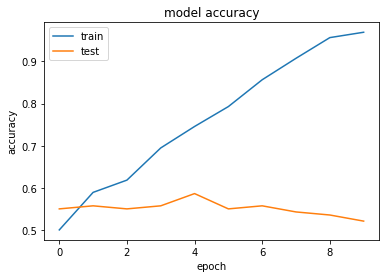

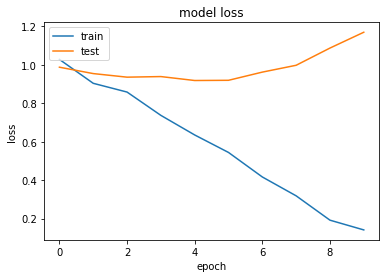

******************** FM *******************
2339
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          701700    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 795,335
Trainable params: 795,335
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
17/17 [==============================] - 2s 126ms/step

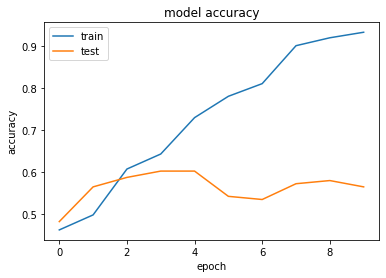

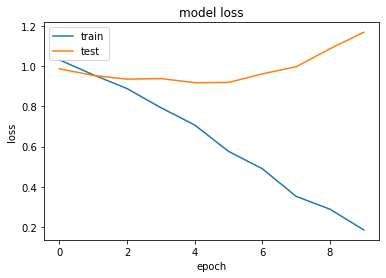

******************** LA *******************
2125
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          637500    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 300, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 731,135
Trainable params: 731,135
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
16/16 [==============================] - 2s 134ms/step

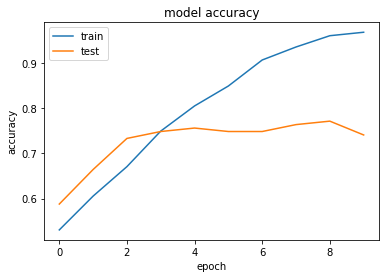

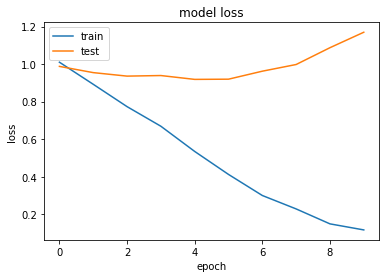

******************** AT *******************
1839
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 300)          551700    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 300, 300)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 645,335
Trainable params: 645,335
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
13/13 [==============================] - 2s 138ms/step

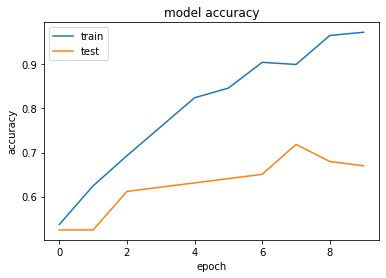

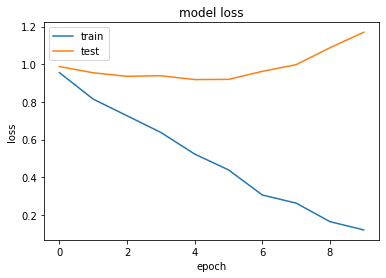

******************** CC *******************
1717
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 300, 300)          515100    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 300, 300)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 195       
Total params: 608,735
Trainable params: 608,735
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
10/10 [==============================] - 1s 146ms/step

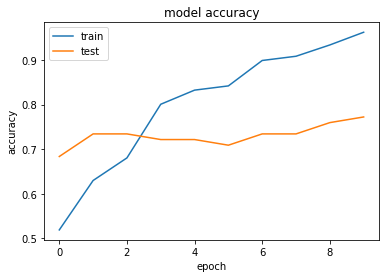

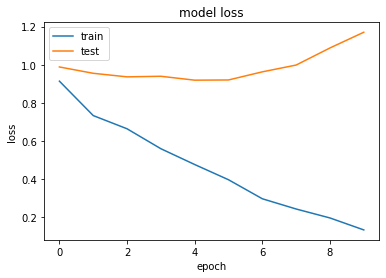

In [50]:
print("******************** HC *******************")
HC = StanceClassifierLSTM(emb_matrix1.shape[0], 3)
HC.built_model(1, emb_dimension, X_train1.shape[1], [emb_matrix1])
HC.get_modelsummary()
history = HC.fit_model(X_train1, Y_train1, X_val1, Y_val1, 10, 32)
pred = HC.predict_model(X_test1)
HC.evaluate_model(X_test1, Y_test1, le1)
HC.display_confusionmatrix(Y_test1)
HC.plot_results()

print("******************** FM *******************")
FM = StanceClassifierLSTM(emb_matrix2.shape[0], 3)
FM.built_model(1, emb_dimension, X_train2.shape[1], [emb_matrix2])
FM.get_modelsummary()
FM.fit_model(X_train2, Y_train2, X_val2, Y_val2, 10, 32)
pred = FM.predict_model(X_test2)
FM.evaluate_model(X_test2, Y_test2, le2)
FM.display_confusionmatrix(Y_test2)
FM.plot_results()

print("******************** LA *******************")
LA = StanceClassifierLSTM(emb_matrix3.shape[0], 3)
LA.built_model(1, emb_dimension, X_train3.shape[1], [emb_matrix3])
LA.get_modelsummary()
LA.fit_model(X_train3, Y_train3, X_val3, Y_val3, 10, 33)
pred = LA.predict_model(X_test3)
LA.evaluate_model(X_test3, Y_test3, le3)
LA.display_confusionmatrix(Y_test3)
LA.plot_results()


print("******************** AT *******************")
AT = StanceClassifierLSTM(emb_matrix4.shape[0], 3)
AT.built_model(1, emb_dimension, X_train4.shape[1], [emb_matrix4])
AT.get_modelsummary()
AT.fit_model(X_train4, Y_train4, X_val4, Y_val4, 10, 33)
pred = AT.predict_model(X_test4)
AT.evaluate_model(X_test4, Y_test4, le4)
AT.display_confusionmatrix(Y_test4)
AT.plot_results()


print("******************** CC *******************")
CC = StanceClassifierLSTM(emb_matrix5.shape[0], 3)
CC.built_model(1, emb_dimension, X_train5.shape[1], [emb_matrix5])
CC.get_modelsummary()
CC.fit_model(X_train5, Y_train5, X_val5, Y_val5, 10, 33)
pred = CC.predict_model(X_test5)
CC.evaluate_model(X_test5, Y_test5, le5)
CC.display_confusionmatrix(Y_test5)
CC.plot_results()

In [51]:
history.history

{'loss': [1.0285239219665527,
  0.9041313529014587,
  0.8585512042045593,
  0.7371878027915955,
  0.6351858377456665,
  0.5441181063652039,
  0.41646379232406616,
  0.31826096773147583,
  0.19154512882232666,
  0.14082463085651398],
 'accuracy': [0.5009074211120605,
  0.5898366570472717,
  0.6188747882843018,
  0.6950998306274414,
  0.745916485786438,
  0.7931034564971924,
  0.8566243052482605,
  0.9074410200119019,
  0.9564428329467773,
  0.9691470265388489],
 'val_loss': [0.9879540801048279,
  0.9547658562660217,
  0.9361207485198975,
  0.9392024874687195,
  0.9186999201774597,
  0.9197920560836792,
  0.962397575378418,
  0.9980154633522034,
  1.087641954421997,
  1.16999089717865],
 'val_accuracy': [0.5507246255874634,
  0.5579710006713867,
  0.5507246255874634,
  0.5579710006713867,
  0.5869565010070801,
  0.5507246255874634,
  0.5579710006713867,
  0.54347825050354,
  0.5362318754196167,
  0.52173912525177]}

### BI-Directional LSTM

In [52]:
class StanceClassifierBiLSTM:
    
    def __init__(self, max_feature, num_classes):
        self.model = Sequential()
        self.max_feature = max_feature
        print(self.max_feature)
        self.num_classes = num_classes
        self.y_pred = 0
        self.history = 0
        
    def built_model(self, layers, emb_dimension, input_length1, emb_matrix):
        
        self.model.add(Embedding(self.max_feature, emb_dimension, input_length=input_length1,weights=emb_matrix,trainable=True))
        
        self.model.add(Bidirectional(LSTM(100, return_sequences=True, dropout=0.25, recurrent_dropout=0.1)))
        self.model.add(GlobalMaxPool1D())
        self.model.add(Dense(64, activation="relu"))
        self.model.add(Dropout(0.25))
        
#         self.model.add(Bidirectional(LSTM(100, return_sequences=True, dropout=0.25, recurrent_dropout=0.1)))
#         self.model.add(GlobalMaxPool1D())
#         self.model.add(Dense(64, activation="relu"))
#         self.model.add(Dropout(0.5))
        
#         self.model.add(SpatialDropout1D(0.5))
#         self.model.add(Bidirectional(LSTM(64,return_sequences=False)))
#         #self.model.add((LSTM(128,return_sequences=False)))
#         self.model.add(Dense(64, activation="relu"))
#         self.model.add(Dropout(0.5))
        
        
        self.model.add(Dense(3, activation='softmax'))
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
    def get_modelsummary(self):
        self.model.summary()
        
    def fit_model(self, X_train, Y_train, X_val, Y_val, epochs, batch_size):
        self.history =  self.model.fit(X_train, Y_train, validation_data=(X_val, Y_val),epochs=epochs,
                             batch_size=batch_size, verbose=1)
        return self.history
    
    def predict_model(self, X_test):
        self.y_pred = self.model.predict(X_test)
        return self.y_pred
    
    def evaluate_model(self, X_test, Y_test, le):
        Y_test = to_categorical(Y_test)
        print("result")
        print(self.model.evaluate(X_test,Y_test))       
        
    def display_confusionmatrix(self, Ytest):
        self.y_test_predicted  = []
        for i in self.y_pred:
            self.y_test_predicted.append(np.argmax(i))
        print(confusion_matrix(Ytest.tolist(), self.y_test_predicted, labels =[0,1,2]))    
        
    def plot_results(self):
        # summarize history for accuracy
        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(self.history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    

******************** HC *******************
2308
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 300, 300)          692400    
_________________________________________________________________
bidirectional (Bidirectional (None, 300, 200)          320800    
_________________________________________________________________
global_max_pooling1d (Global (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                12864     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 195       
Total params: 1,026,259
Trainable params: 1,026,259
Non-trainable param

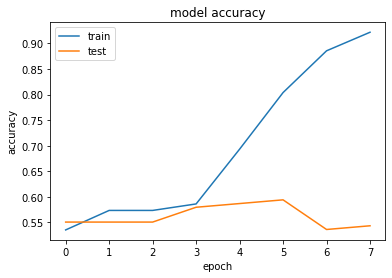

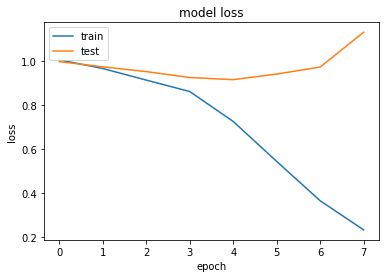

******************** FM *******************
2339
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 300, 300)          701700    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 300, 200)          320800    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                12864     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 195       
Total params: 1,035,559
Trainable params: 1,035,559
Non-trainable param

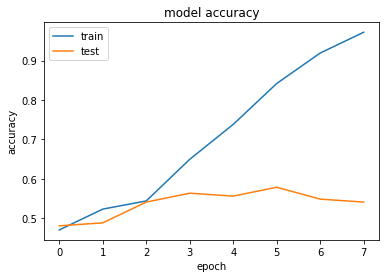

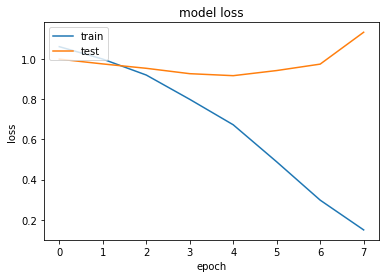

******************** LA *******************
2125
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 300, 300)          637500    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 300, 200)          320800    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                12864     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 195       
Total params: 971,359
Trainable params: 971,359
Non-trainable params: 0

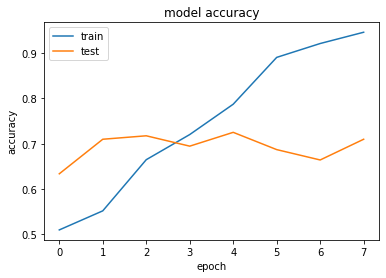

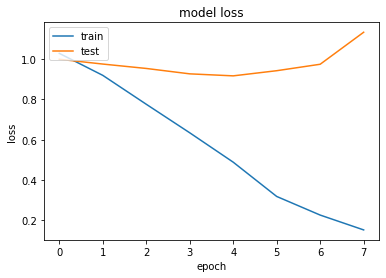

******************** AT *******************
1839
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 300, 300)          551700    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 300, 200)          320800    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 200)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                12864     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 195       
Total params: 885,559
Trainable params: 885,559
Non-trainable params: 0

KeyboardInterrupt: 

In [53]:

print("******************** HC *******************")
HC1 = StanceClassifierBiLSTM(emb_matrix1.shape[0], 3)
HC1.built_model(1, emb_dimension, X_train1.shape[1], [emb_matrix1])
HC1.get_modelsummary()
history = HC1.fit_model(X_train1, Y_train1, X_val1, Y_val1, 8, 32)
pred = HC1.predict_model(X_test1)
HC1.evaluate_model(X_test1, Y_test1, le1)
HC1.display_confusionmatrix(Y_test1)
HC1.plot_results()

print("******************** FM *******************")
FM1 = StanceClassifierBiLSTM(emb_matrix2.shape[0], 3)
FM1.built_model(1, emb_dimension, X_train2.shape[1], [emb_matrix2])
FM1.get_modelsummary()
FM1.fit_model(X_train2, Y_train2, X_val2, Y_val2, 8, 32)
pred = FM1.predict_model(X_test2)
FM1.evaluate_model(X_test2, Y_test2, le2)
FM1.display_confusionmatrix(Y_test2)
FM1.plot_results()

print("******************** LA *******************")
LA1 = StanceClassifierBiLSTM(emb_matrix3.shape[0], 3)
LA1.built_model(1, emb_dimension, X_train3.shape[1], [emb_matrix3])
LA1.get_modelsummary()
LA1.fit_model(X_train3, Y_train3, X_val3, Y_val3, 8, 33)
pred = LA1.predict_model(X_test3)
LA1.evaluate_model(X_test3, Y_test3, le3)
LA1.display_confusionmatrix(Y_test3)
LA1.plot_results()


print("******************** AT *******************")
AT1 = StanceClassifierBiLSTM(emb_matrix4.shape[0], 3)
AT1.built_model(1, emb_dimension, X_train4.shape[1], [emb_matrix4])
AT1.get_modelsummary()
AT1.fit_model(X_train4, Y_train4, X_val4, Y_val4, 8, 33)
pred = AT1.predict_model(X_test4)
AT1.evaluate_model(X_test4, Y_test4, le4)
AT1.display_confusionmatrix(Y_test4)
AT1.plot_results()


print("******************** CC *******************")
CC1 = StanceClassifierBiLSTM(emb_matrix5.shape[0], 3)
CC1.built_model(1, emb_dimension, X_train5.shape[1], [emb_matrix5])
CC1.get_modelsummary()
CC1.fit_model(X_train5, Y_train5, X_val5, Y_val5, 8, 33)
pred = CC1.predict_model(X_test5)
CC1.evaluate_model(X_test5, Y_test5, le5)
CC1.display_confusionmatrix(Y_test5)
CC1.plot_results()

In [58]:
from sklearn.metrics import classification_report

### Bidirectional GRU Model (BI-GRU)

In [59]:
class StanceClassifierGRU:
    
    def __init__(self, max_feature, num_classes):
        self.model = Sequential()
        self.max_feature = max_feature
        print(self.max_feature)
        self.num_classes = num_classes
        self.y_pred = 0
        self.history = 0
        
    def built_model(self, layers, emb_dimension, input_length1, emb_matrix):
        
        self.model.add(Embedding(self.max_feature, emb_dimension, input_length=input_length1,weights=emb_matrix,trainable=True))
        
        self.model.add(SpatialDropout1D(0.5))
        self.model.add(Bidirectional(GRU(128)))
        self.model.add(Dense(128, activation='relu'))
        self.model.add(Dropout(0.2))
        
        self.model.add(Dense(3, activation='softmax'))
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
    def get_modelsummary(self):
        self.model.summary()
        
    def fit_model(self, X_train, Y_train, X_val, Y_val, epochs, batch_size):
        self.history =  self.model.fit(X_train, Y_train, validation_data=(X_val, Y_val),epochs=epochs,
                             batch_size=batch_size, verbose=1)
        return self.history
    
    def predict_model(self, X_test):
        self.y_pred = self.model.predict(X_test)
        return self.y_pred
    
    def evaluate_model(self, X_test, Y_test, le):
        Y_test = to_categorical(Y_test)
        print("result")
        print(self.model.evaluate(X_test,Y_test))       
        
    def display_confusionmatrix(self, Ytest):
        self.y_test_predicted  = []
        for i in self.y_pred:
            self.y_test_predicted.append(np.argmax(i))
        print(confusion_matrix(Ytest.tolist(), self.y_test_predicted, labels =[0,1,2]))
        print(classification_report(y_true, y_pred, target_names=target_names))
        
    def plot_results(self):
        # summarize history for accuracy
        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(self.history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    

******************** HC *******************
2308
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 300, 300)          692400    
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 300, 300)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               330240    
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 387       
Total params: 1,055,923
Trainable params: 1,055,923
Non-trainable param

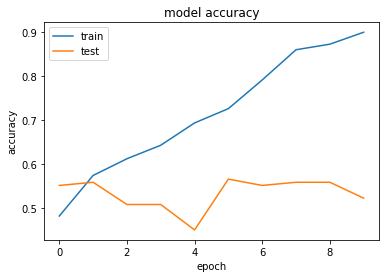

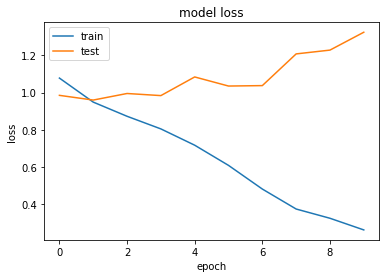

******************** FM *******************
2339
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 300, 300)          701700    
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 300, 300)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               330240    
_________________________________________________________________
dense_15 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 387       
Total params: 1,065,223
Trainable params: 1,065,223
Non-trainable para

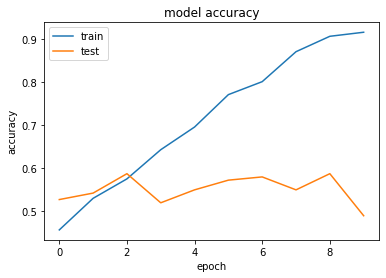

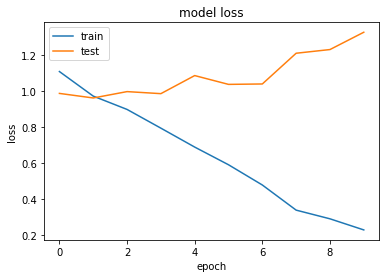

******************** LA *******************
2125
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 300, 300)          637500    
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 300, 300)          0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 256)               330240    
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 387       
Total params: 1,001,023
Trainable params: 1,001,023
Non-trainable para

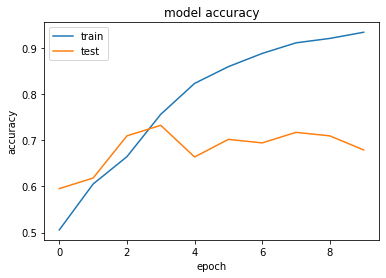

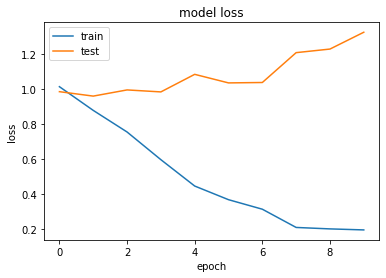

******************** AT *******************
1839
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 300, 300)          551700    
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 300, 300)          0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 256)               330240    
_________________________________________________________________
dense_19 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 387       
Total params: 915,223
Trainable params: 915,223
Non-trainable params: 

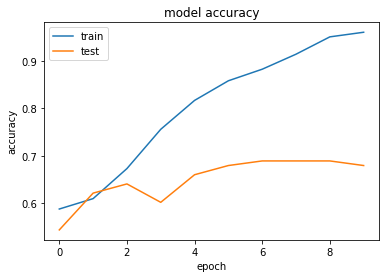

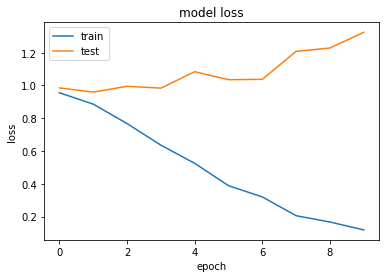

******************** CC *******************
1717
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 300, 300)          515100    
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 300, 300)          0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 256)               330240    
_________________________________________________________________
dense_21 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 3)                 387       
Total params: 878,623
Trainable params: 878,623
Non-trainable params: 

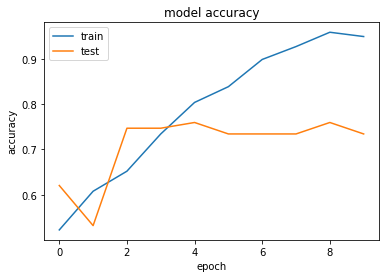

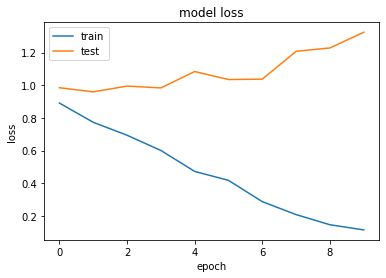

In [55]:
print("******************** HC *******************")
HC2 = StanceClassifierGRU(emb_matrix1.shape[0], 3)
HC2.built_model(1, emb_dimension, X_train1.shape[1], [emb_matrix1])
HC2.get_modelsummary()
history = HC2.fit_model(X_train1, Y_train1, X_val1, Y_val1, 10, 32)
pred = HC2.predict_model(X_test1)
HC2.evaluate_model(X_test1, Y_test1, le1)
HC2.display_confusionmatrix(Y_test1)
HC2.plot_results()

print("******************** FM *******************")
FM2 = StanceClassifierGRU(emb_matrix2.shape[0], 3)
FM2.built_model(1, emb_dimension, X_train2.shape[1], [emb_matrix2])
FM2.get_modelsummary()
FM2.fit_model(X_train2, Y_train2, X_val2, Y_val2, 10, 32)
pred = FM2.predict_model(X_test2)
FM2.evaluate_model(X_test2, Y_test2, le2)
FM2.display_confusionmatrix(Y_test2)
FM2.plot_results()

print("******************** LA *******************")
LA2 = StanceClassifierGRU(emb_matrix3.shape[0], 3)
LA2.built_model(1, emb_dimension, X_train3.shape[1], [emb_matrix3])
LA2.get_modelsummary()
LA2.fit_model(X_train3, Y_train3, X_val3, Y_val3, 10, 33)
pred = LA2.predict_model(X_test3)
LA2.evaluate_model(X_test3, Y_test3, le3)
LA2.display_confusionmatrix(Y_test3)
LA2.plot_results()

print("******************** AT *******************")
AT2 = StanceClassifierGRU(emb_matrix4.shape[0], 3)
AT2.built_model(1, emb_dimension, X_train4.shape[1], [emb_matrix4])
AT2.get_modelsummary()
AT2.fit_model(X_train4, Y_train4, X_val4, Y_val4, 10, 33)
pred = AT2.predict_model(X_test4)
AT2.evaluate_model(X_test4, Y_test4, le4)
AT2.display_confusionmatrix(Y_test4)
AT2.plot_results()

print("******************** CC *******************")
CC2 = StanceClassifierGRU(emb_matrix5.shape[0], 3)
CC2.built_model(1, emb_dimension, X_train5.shape[1], [emb_matrix5])
CC2.get_modelsummary()
CC2.fit_model(X_train5, Y_train5, X_val5, Y_val5, 10, 33)
pred = CC2.predict_model(X_test5)
CC2.evaluate_model(X_test5, Y_test5, le5)
CC2.display_confusionmatrix(Y_test5)
CC2.plot_results()

7175
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 300, 300)          2152500   
_________________________________________________________________
spatial_dropout1d_10 (Spatia (None, 300, 300)          0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 256)               330240    
_________________________________________________________________
dense_23 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 3)                 387       
Total params: 2,516,023
Trainable params: 2,516,023
Non-trainable params: 0
______________________________________

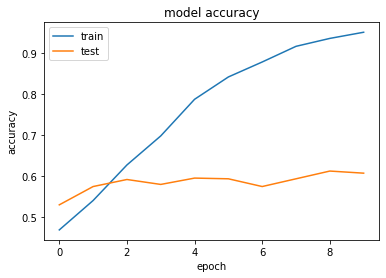

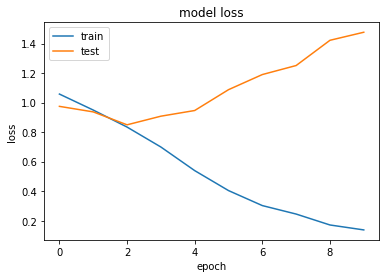

In [56]:
GEN = StanceClassifierGRU(emb_matrix6.shape[0], 3)
GEN.built_model(1, emb_dimension, X_train6.shape[1], [emb_matrix6])
GEN.get_modelsummary()
history = GEN.fit_model(X_train6, Y_train6, X_val6, Y_val6, 10, 32)
pred = GEN.predict_model(X_test6)
GEN.evaluate_model(X_test6, Y_test6, le6)
GEN.display_confusionmatrix(Y_test6)
GEN.plot_results()

## Independent Evaluation

******************** HC *******************
result
1/1 [==============================] - 0s 997us/step - loss: 1.8334 - accuracy: 0.3077
[1.8334136009216309, 0.3076923191547394]
[[2 0 5]
 [2 1 1]
 [0 1 1]]


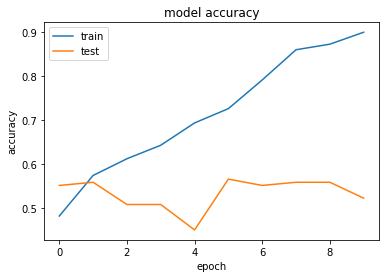

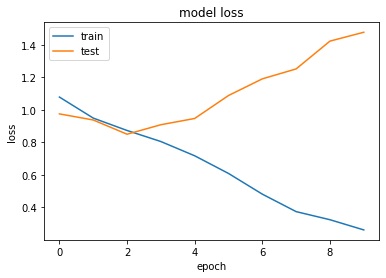

******************** FM *******************
result
1/1 [==============================] - 0s 997us/step - loss: 1.7282 - accuracy: 0.6667
[1.7281965017318726, 0.6666666865348816]
[[1 1 0]
 [0 5 0]
 [0 2 0]]


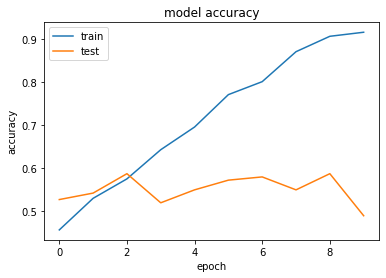

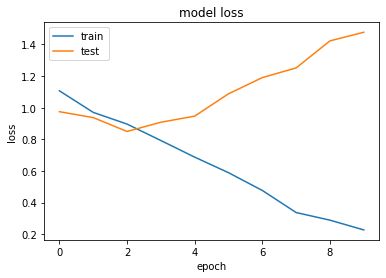

******************** AT *******************
result
1/1 [==============================] - 0s 3ms/step - loss: 4.7978 - accuracy: 0.2222
[4.797765731811523, 0.2222222238779068]
[[1 0 0]
 [5 1 0]
 [2 0 0]]


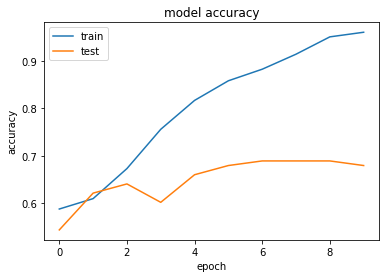

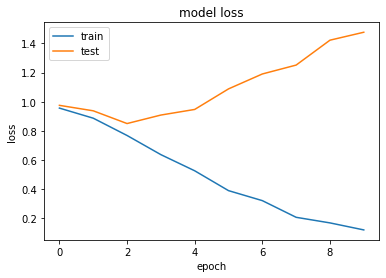

In [57]:
print("******************** HC *******************")

pred = HC2.predict_model(X_indp1)
HC2.evaluate_model(X_indp1, Y_indp1, le1)
HC2.display_confusionmatrix(Y_indp1)
HC2.plot_results()

print("******************** FM *******************")

pred = FM2.predict_model(X_indp2)
FM2.evaluate_model(X_indp2, Y_indp2, le2)
FM2.display_confusionmatrix(Y_indp2)
FM2.plot_results()

print("******************** AT *******************")
pred = AT2.predict_model(X_indp4)
AT2.evaluate_model(X_indp4, Y_indp4, le4)
AT2.display_confusionmatrix(Y_indp4)
AT2.plot_results()

print("******************** LA *******************")
pred = LA.predict_model(X_indp3)
LA.evaluate_model(X_indp3, Y_indp3, le3)
LA.display_confusionmatrix(Y_indp3)
LA.plot_results()

print("******************** CC *******************")
pred = CC.predict_model(X_indp5)
FM.evaluate_model(X_indp5, Y_indp5, le5)
FM.display_confusionmatrix(Y_indp5)
FM.plot_results()